# DS 7333 - Quantifying the World
## Case Study #3

Sterling Beason, Sean Kennedy, Emil Ramos

In [1]:
import pandas as pd
from IPython.display import SVG

# IMPORTANT: install rpy2 v3.3.x
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score
from sklearn.pipeline import Pipeline

# Recommended Installation: 'conda install python-graphviz' (should add 'graphviz' to PATH)
from graphviz import Source
import seaborn as sns

### Import R Data and Convert to Pandas DataFrame

In [2]:
base = importr('base')
base.load("./Data/data.Rda")
rdf_List = base.mget(base.ls())

with localconverter(ro.default_converter + pandas2ri.converter):
    df = ro.conversion.rpy2py(rdf_List[0]) # convert 'emailDFrp' dataset
    
df = df.reset_index()
df = df.drop('index', 1)

df

,isSpam,isRe,underscore,priority,isInReplyTo,sortedRec,subPunc,multipartText,hasImages,isPGPsigned,...,subQuesCt,numAtt,numRec,perCaps,hour,perHTML,subBlanks,forwards,avgWordLen,numDlr
0,F,T,F,F,T,T,F,F,F,F,...,0,0.0,2,4.451039,11.0,0.000000,12.500000,0.000000,4.376623,3
1,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.491289,11.0,0.000000,8.000000,0.000000,4.555556,0
2,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.436096,12.0,0.000000,8.000000,0.000000,4.817164,0
3,F,F,F,F,F,T,F,F,F,F,...,0,0.0,0,5.090909,13.0,0.000000,18.918919,3.125000,4.714286,0
4,F,T,F,F,F,T,F,F,F,F,...,0,0.0,1,6.116643,13.0,0.000000,15.217391,6.451613,4.234940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9343,T,F,F,F,F,T,F,F,F,F,...,1,0.0,1,8.572552,21.0,79.657111,13.793103,0.000000,4.700555,2
9344,T,F,F,F,F,T,F,T,F,F,...,0,1.0,1,9.436009,23.0,0.000000,10.526316,0.000000,4.904255,4
9345,T,F,F,F,F,F,F,F,F,F,...,0,0.0,1,2.418448,8.0,0.000000,20.000000,0.000000,4.703704,0
9346,T,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.795400,23.0,0.000000,5.263158,0.000000,5.252690,80


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   isSpam         9348 non-null   category
 1   isRe           9348 non-null   category
 2   underscore     9348 non-null   category
 3   priority       9348 non-null   category
 4   isInReplyTo    9348 non-null   category
 5   sortedRec      9348 non-null   category
 6   subPunc        9348 non-null   category
 7   multipartText  9348 non-null   category
 8   hasImages      9348 non-null   category
 9   isPGPsigned    9348 non-null   category
 10  subSpamWords   9341 non-null   category
 11  noHost         9347 non-null   category
 12  numEnd         9348 non-null   category
 13  isYelling      9341 non-null   category
 14  isOrigMsg      9348 non-null   category
 15  isDear         9348 non-null   category
 16  isWrote        9348 non-null   category
 17  numLines       9348 non-null   in

In [4]:
print(df.isna().any())

isSpam           False
isRe             False
underscore       False
priority         False
isInReplyTo      False
sortedRec        False
subPunc          False
multipartText    False
hasImages        False
isPGPsigned      False
subSpamWords      True
noHost            True
numEnd           False
isYelling         True
isOrigMsg        False
isDear           False
isWrote          False
numLines         False
bodyCharCt       False
subExcCt         False
subQuesCt        False
numAtt           False
numRec           False
perCaps          False
hour             False
perHTML          False
subBlanks         True
forwards         False
avgWordLen       False
numDlr           False
dtype: bool


There are 4 columns with NAs 

- subSpamWords (category)

- noHost (category)

- isYelling (category)

- subBlanks (float)

Let's analyze the categorical variables first:

***subSpamWords***


In [5]:
df.subSpamWords.unique()

[F, T, NaN]
Categories (2, object): [F, T]

[Text(0, 0, '0'),
 Text(0, 0, '1,000'),
 Text(0, 0, '2,000'),
 Text(0, 0, '3,000'),
 Text(0, 0, '4,000'),
 Text(0, 0, '5,000'),
 Text(0, 0, '6,000'),
 Text(0, 0, '7,000'),
 Text(0, 0, '8,000')]

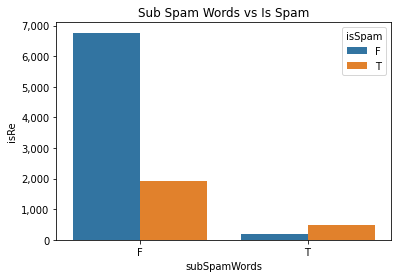

In [6]:
spam_na = df[df.subSpamWords.isna()]
group_by_spam = df.groupby(['subSpamWords', 'isSpam']).count().reset_index()
p1 = sns.barplot(data = group_by_spam, x='subSpamWords', y='isRe', hue='isSpam')
p1.set_title('Sub Spam Words vs Is Spam')
y_ticklabels = [f'{y:,.0f}' for y in p1.get_yticks()]
p1.set_yticklabels(y_ticklabels)


### Data Partioning

In [7]:
df = df.dropna() # TODO: Impute NAs, don't drop them

features = df[df.columns.difference(['isSpam'])]


X = pd.get_dummies(features, drop_first=True)
y = df['isSpam'].astype('object').apply(lambda x: 1 if x == 'T' else 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7333)

### Modeling - Decision Tree

In [8]:
clf = DecisionTreeClassifier(random_state=7333)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

# Accuracy
precision_score(y_test, pred)

0.9302325581395349

In [9]:
clf.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'random_state': 7333,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': 'deprecated',
 'ccp_alpha': 0.0,
 'n_features_': 29,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 29,
 'tree_': <sklearn.tree._tree.Tree at 0x7fda7fab7308>}

In [10]:
n_splits = 5
cv = StratifiedShuffleSplit(n_splits,test_size=.2, train_size=.8, random_state=7333)

In [49]:
criteria = ['gini', 'entropy'] # define possible splitting criteria
splitters = ['best', 'random'] 
max_depth = list(range(20, 100, 5))
min_samples_split = list(range(1,5, 1))
min_samples_leaf = list(range(5, 50, 3))
max_features = ['auto', 'sqrt', 'log2']
random_state = 7333
min_fraction = None
max_leaf_nodes = [range(5, 20, 3)]
scoring = {
            'Accuracy':'accuracy'
            , 'F-1 Score':'f1'
            , 'AUC':'roc_auc'
            , 'Precision':'precision'
}

### Model Tuning:

General grid search:

In [12]:
pipe = Pipeline(steps=[('decision_tree', clf)])
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 #'decision_tree__criterion':criteria,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Precision score of best estimator: 0.9158110882956879


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [13]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [14]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
results[scores].sort_values(['rank_test_Precision']).T

,1,0
split0_test_Precision,0.919355,0.91601
split1_test_Precision,0.929155,0.915567
split2_test_Precision,0.916883,0.941645
split3_test_Precision,0.934605,0.937158
split4_test_Precision,0.927419,0.910026
mean_test_Precision,0.925484,0.924081
std_test_Precision,0.00651087,0.0127645
rank_test_Precision,1,2
params,{'decision_tree__criterion': 'entropy'},{'decision_tree__criterion': 'gini'}


**Entropy** appears slightly better.... given that this precision is worse than baseline, we should continue our search and consider sticking with **gini**.

In [15]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Precision score of best estimator: 0.9564270152505446


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


In [16]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [17]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
sorted_results[1].params

{'decision_tree__criterion': 'gini', 'decision_tree__splitter': 'random'}

In [18]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s


Precision score of best estimator: 0.9653579676674365


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    2.3s finished


In [19]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [20]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
sorted_results[1].params

{'decision_tree__criterion': 'gini',
 'decision_tree__max_depth': 20,
 'decision_tree__splitter': 'random'}

Setting max_depth = 20 seems to have a sizeable improvement on Precision, let's keep that in mind.

In [34]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    6.3s


Precision score of best estimator: 0.9653579676674365


[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:    6.9s finished


In [37]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [39]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
sorted_results[1].params

{'decision_tree__criterion': 'gini',
 'decision_tree__max_depth': 20,
 'decision_tree__min_samples_split': 1,
 'decision_tree__splitter': 'random'}

**min_samples_split** seems to best at the lowest possible value: explanantion?

In [50]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 9656 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 12656 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 16056 tasks      | elapsed:  1.3min


Precision score of best estimator: 0.9108695652173913


[Parallel(n_jobs=-1)]: Done 19200 out of 19200 | elapsed:  1.6min finished


In [51]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [52]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
sorted_results[1].params

{'decision_tree__criterion': 'gini',
 'decision_tree__max_depth': 20,
 'decision_tree__min_samples_leaf': 5,
 'decision_tree__min_samples_split': 1,
 'decision_tree__splitter': 'random'}

### Display Decision Tree

**Note:** You may have to scroll to view

In [22]:
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['spam', 'ham'], filled = True))

display(SVG(graph.pipe(format='svg')))

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH